# Week-4: Part-2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Set size of figure
plt.rcParams['figure.figsize'] = [8, 8]
# Set size of font
plt.rcParams['font.size'] = 10

## GMM

Now that we know how to sample from simple distributions like the Bernoulli and Gaussian, we shall move to sampling from a GMM. There are two steps here:

- Pick a mixture $k$ from $K$ mixtures based on the categorical distribution governing it
- Sample a point from the $k^{th}$ Gaussian

## Problem-1

Consider a GMM with $K = 3$. The mixture probabilities are given below. It is easier to work with zero-indexing, hence we will index our mixtures starting from $0$:

$$
\pi_0 = 0.3\\
\pi_1 = 0.5\\
\pi_2 = 0.2
$$

Perform step-1 of the sampling process by choosing one of the three mixtures based on the above distribution. Call this value $k$. Use the cell given below for all your computation. Do not change the seed value. Enter $k$ as your answer.

In [3]:
### RNG ###
rng = np.random.default_rng(seed = 1001)
### Solution ###
k = rng.choice([0,1,2],size=1, p=[0.3,0.5,0.2])
print(k)

[1]


## Problem-2

Now we move to step-2 of the sampling process. Sample a point from mixture $k$ (obtained from the previous question). The means and variances of the mixtures are as follows:

$$
\mu_1 = -4, \sigma_1^2 = 2\\
\mu_2 = 0, \sigma_2^2 = 1\\
\mu_3 = 5, \sigma_3^2 = 3
$$


Use the cell given below for all your computation. Enter the sampled point correct to three decimal places.

In [14]:
### RNG ###
rng = np.random.default_rng(seed = 1001)
### Solution ###
#so we need to sample a point from the 2nd mixture
rng.normal(0,1,size=1)


array([0.93232244])

## Problem-3

Now that we have sampled one point, we are ready to do more. Sample $100,000$ points from the GMM. Generate each point step by step. Store the samples in a NumPy array `X` of shape $(100,000, )$. `X[i]` should hold the value of the $i^{th}$ point generated from the GMM.  Use the cell below for all your computation. Enter the mean of `X` as your answer correct to three decimal places.

In [20]:
### RNG ###
rng = np.random.default_rng(seed = 1001)
### Solution ###
X = np.empty(100_000)
mu = np.array([-4,0,5])
sigma = np.array([2,1,3])**0.5 
for i in range(1000_00):
    k = rng.choice([0,1,2],size=1,p=[0.3,0.5,0.2])
    X[i] = rng.normal(mu[k],sigma[k],size=1)
print(np.mean(X), X.shape)

-0.1930762698848285 (100000,)


## Problem-4

Plot a histogram of the dataset. Play around with the `bins` parameter of the `plt.hist` method. We will be using this dataset `X` all through the next section of the colab.

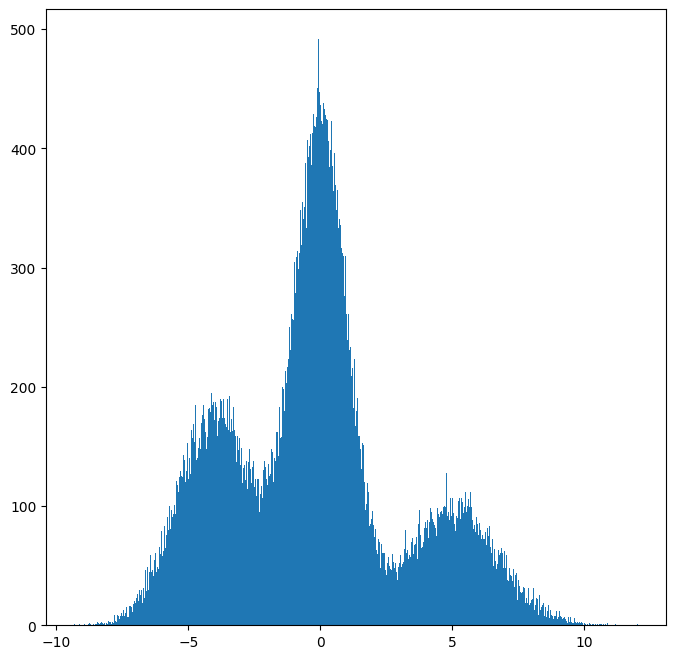

In [23]:
### Solution ###
plt.hist(X,bins=1000)
plt.show()

## EM algorithm

It is time to start coding up the EM algorithm from scratch. We will break this down into five stages:

- Initialization
- E-step
- M-step
- Stopping criterion
- Algorithm

For each of the first four stages, we will write functions that are related to that stage. All these functions will be eventually used in the code for the EM algorithm. This is a modular approach to writing the code. We have identified four blocks or stages. We can independently work on these four blocks and finally combine them. If something goes wrong, we can quickly localize the problem to one of these four blocks.


## Problem-5

Write a function `init` that initializes the parameters of the GMM and returns `theta_0`, a NumPy array of shape $(3K, )$. The first $K$ elements of `theta_0` ($\boldsymbol{\theta}^{(0)}$) represents the means of the three mixtures, the next $K$ represent the variances and the last $K$ represent the mixture probabilities.

The exact values to be used are as follows:

- $\mu_0 = 1, \mu_1 = 2, \mu_2 = 3$
- $\sigma_0^2 = \sigma_1^2 = \sigma_2^2 = 1$
- $\pi_0 = \pi_1 = \pi_2 = 1/3$ 

Enter $||\boldsymbol{\theta}^{(0)}||$ as your answer correct to two decimal places. Keep this variable `theta_0` as it will be used in subsequent problems.

In [24]:
### Solution ###
def init():
    return np.array([1,2,3,1,1,1,1/3,1/3,1/3])
theta_0 = init()
print(np.linalg.norm(theta_0))

4.163331998932265


## Problem-6

Write a function `estep` that accepts `theta` and `X` as arguments. It should perform the E-step and return an array `lamb` of shape `(n, K)`. The element `lamb[i][k]` is equal to $\lambda_k^{i}$. For the purposes of evaluation, run the function on `theta_0` and `X`. Call the returned value `lamb_1`.  Compute the sum of the zeroth column of the matrix `lamb_1` and enter that as your answer correct to two decimal places. Keep this variable `lamb_1` as it will be used in subsequent problems.


**Aside**: We prefer the variable name `lamb` over `lambda` for a reason. Can you guess why?

Probability of $x_i$ being from any mixture $k$ is equal to conditional probability of $z_i = k$ given the datapoint $x_i$
$$\lambda_k^i = P(\ z_i = k | x_i )\$$
$$\lambda_k^i = \frac{P( z_i = k) . f( x_i | z_i = k )}{f(x_i)}$$
$$\lambda_k^i = \frac{\pi_k . f( x_i | z_i = k)}{f(x_i)}$$
$$f(\ x_i) = \sum^{K}_{l=1}{\pi_l . f(x_i| z_i =  l)}$$
$$\lambda_k^i = \frac{\pi_k . f( x_i | z_i = k)}{\sum^{K}_{l=1}{\pi_l . f(x_i| z_i =  l)}} $$

In [33]:
### Solution ###
# def estep(theta,X):
def gaussian(mu,sigma,x):
    return (np.exp((-1 * (x-mu)**2)/(2*sigma**2)))/np.sqrt(2* np.pi)*sigma

def estep(X,theta):
    K = int(theta.shape[0]/3)
    n = theta.shape[0]
    mu = theta[:K]
    sigma = theta[K:2*K]**0.5
    pi = theta[2*K : 3*K]
    lamb = np.empty((n,K))
    for i in range(n):
        evidence = sum([pi[k] * gaussian(mu[k],sigma[k],X[i]) for k in range(K)])
        for k in range(K):
            prior = pi[k]
            likelihood = gaussian(mu[k],sigma[k],X[i] )
            posterior = likelihood * prior/evidence
            lamb[i][k] = posterior
    return lamb

lamb1 = estep(X,theta_0)
np.sum(lamb1[0])


    

1.0

## Problem-7

Write a function `mstep` that accepts `lamb` and `X` as arguments. It should perform the M-step and return a NumPy array `theta`, the updated parameters, namely. We follow the same convention for storing the parameters as was done during the init step. For the purposes of evaluation, compute the value of the function for `lamb_1` and `X`. Call the returned value `theta_1` ($\boldsymbol{\theta}^{(1)}$). Enter $||\boldsymbol{\theta}^{(1)}||$  as your answer correct to two decimal places.

In [9]:
### Solution ###
def mstep(lamb,X):
    n, K = lamb.shape
    mu = np.empty(K)
    sigma = np.empty(K)
    pi = np.empty(K)
    for k in range(K):
        num,den = 0,0
        for i in range(n):
            num += X[i]*lamb[i][k]
            den += lamb[i][k]                   
        mu[k] = num/den
        sigma[k] =     

## Problem-8

Given two vectors $\boldsymbol{\theta}^{(t)}$ and $\boldsymbol{\theta}^{(t + 1)}$, write a function `distance` that accepts these two vectors as arguments and returns the distance between them:

$$
||\boldsymbol{\theta}^{(t + 1)} - \boldsymbol{\theta}^{(t)}||
$$

For the purposes of evaluation, compute the distance between $\boldsymbol{\theta}^{(0)}$ and $\boldsymbol{\theta}^{(1)}$ and report your answer correct to two decimal places.

In [10]:
### Solution ###

## Problem-9

Perform the EM algorithm until convergence. The stopping-criterion is that the distance between the two parameter-vectors should be less than $0.01$.

$$
||\boldsymbol{\theta}^{(t + 1)} - \boldsymbol{\theta}^{(t)}|| < 0.01
$$


Initialize the parameters to $\boldsymbol{\theta}^{(0)}$. Find the number of iterations it takes for the algorithm to converge. Enter this as your answer. 

This is going to take some time. Hold tight!

In [11]:
### Solution ###

## Problem-10

Let us now verify the correctness of our algorithm. We know the true parameters here:

$$
\boldsymbol{\theta} = \begin{bmatrix}
-4\\
0\\
5\\
2\\
1\\
3\\
0.3\\
0.5\\
0.2
\end{bmatrix}
$$

Let $\boldsymbol{\theta}^{*}$ be the parameter at convergence. Compute the distance between this vector and the true parameter vector. Enter your answer correct to two decimal places. The smaller the distance, better our estimate.

In [12]:
### Solution ###

## Problem-11

We shall do a hard clustering of the data-points. Use the final `lamb` value obtained and cluster the points using:

$$
z_i = \operatorname*{argmax} \limits_{k} \lambda_k^{i}
$$

Let $0$, $1$ and $2$ correspond to the colors red, blue and green respectively. Plot three colored histograms on the same figure, one for each cluster.

In [13]:
### Solution ###

## Extras

Here are some of the things that can be tried out:

- Make the stopping criterion more stringent and see the effect it has on the number of iterations
- Change the size of the dataset and study the effect it has on convergence.
- Change the initialization and study the effect it has on convergence
- Change the number of mixtures and see what happens